In [11]:
from datetime import datetime
from glob import glob
import os

from keras import Input, Model
from keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten
from matplotlib import pyplot as plt
from numpy import interp
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import label_binarize
import tensorflow as tf
import tensorflow.keras as k
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.ops.confusion_matrix import confusion_matrix


In [12]:
DEBUG = 1
SAVE = 0

BATCH = 256
EPOCH = 256
ES = 64

MIN, MAX = 0, 255
CLASS = [0, 1]

## FUNCTIONS

In [13]:
def log(l):
  if DEBUG == 1: print(l)


def draw_CM(label, predicted):
  cm = confusion_matrix(label, predicted)
  sns.heatmap(cm, annot=True, fmt="d")
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  # true : false rate
  true = 0
  false = 0
  for i, j in enumerate(label):
    if j != predicted[i]:
      false += 1
    else: true += 1
  classification_report = metrics.classification_report(label, predicted)
  multilabel_to_binary_matrics = metrics.multilabel_confusion_matrix(label, predicted)

  return plt.show(), print('true rate: ', true), print('false rate: ', false), print(), print('='*10,
                                                                                              'classification_report: ',
                                                                                              '\n',
                                                                                              classification_report), print(
    '='*10, 'multilabel_to_binary_matrics by class_num: ', '\n', '[[TN / FP] [FN / TP]]',
    '\n', multilabel_to_binary_matrics)


def draw_ROC_AUC(x, y, category_names):
  n_classes = len(category_names)

  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(y[:, i], x[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

  fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y.ravel(), x.ravel())
  roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])

  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

  mean_tpr /= n_classes

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

  plt.figure()
  plt.plot(fpr["micro"], tpr["micro"],
           label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
           color='deeppink', linestyle=':', linewidth=1)

  plt.plot(fpr["macro"], tpr["macro"],
           label=f'macro-average ROC curve (area = {roc_auc["macro"]:0.2f})',
           color='navy', linestyle=':', linewidth=1)

  colors = (['purple', 'pink', 'red', 'green', 'yellow', 'cyan', 'magenta', 'blue'])
  for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1, label=f'Class {i} ROC curve (area = {roc_auc[i]:0.2f})')

  plt.plot([0, 1], [0, 1], 'k--', lw=1)
  plt.xlim([-.01, 1.0])
  plt.ylim([0.0, 1.01])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC & AUC')
  plt.legend(loc="lower right")

  return plt.show()


## DATASET

In [14]:
base_dir = "out"
img_list = glob(f"{base_dir}/*.png")
df = pd.read_csv(f"{base_dir}/output(err_dropped).csv")
log(df.head)

col = list(df.columns)
log(col)

<bound method NDFrame.head of                      img  cnt
0      1650315736806.png    0
1      1650315796123.png    0
2      1650315856514.png    0
3      1650315917006.png    0
4      1650315976418.png    0
...                  ...  ...
27285  1652664376966.png    0
27286  1652664436118.png    0
27287  1652664496517.png    0
27288  1652664556896.png    2
27289  1652664616301.png    0

[27290 rows x 2 columns]>
['img', 'cnt']


## PRE-PROCESS

In [15]:
## PATH TO REAL_PATH
for i in range(len(df)):
  df.iloc[i, 0] = f"{base_dir}/{df.iloc[i, 0]}"

## GET H,W
sample_img = Image.open(df.iloc[16, 0])
img_array = np.array(sample_img, int)
H, W = img_array.shape

## DATASET TO TENSOR
data = []
label = []
for index, row in df.iterrows():
  img = Image.open(row[col[0]])
  img = data.append(list(img.getdata()))
  lbl = label.append(row[col[1]])
  if index % 1000 == 0:  log(index)

data = np.array(data)
data = data.reshape(data.shape[0], H, W, 1)

label = np.array(label)
label = label.reshape(label.shape[0], 1)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000


In [16]:
## Nomalize
log(data[100:102])
norm_data = data/MAX
log(norm_data[100:102])

## Split
split = int(len(label)*0.9)
train_data, test_data = norm_data[:split], norm_data[split:]
train_label, test_label = label[:split], label[split:]


[[[[ 0]
   [ 0]
   [ 0]
   ...
   [ 0]
   [ 0]
   [ 0]]

  [[ 0]
   [ 0]
   [ 0]
   ...
   [ 0]
   [ 0]
   [ 0]]

  [[ 0]
   [ 0]
   [ 0]
   ...
   [ 0]
   [ 0]
   [ 0]]

  ...

  [[ 0]
   [ 0]
   [ 0]
   ...
   [ 0]
   [ 0]
   [ 0]]

  [[ 0]
   [ 0]
   [ 0]
   ...
   [ 0]
   [ 0]
   [ 0]]

  [[ 0]
   [ 0]
   [ 0]
   ...
   [ 0]
   [ 0]
   [ 0]]]


 [[[ 0]
   [ 0]
   [ 0]
   ...
   [ 0]
   [ 0]
   [ 0]]

  [[ 0]
   [ 0]
   [ 0]
   ...
   [ 0]
   [ 0]
   [ 0]]

  [[ 0]
   [ 0]
   [ 0]
   ...
   [ 0]
   [ 0]
   [ 0]]

  ...

  [[ 0]
   [ 0]
   [ 0]
   ...
   [ 0]
   [ 0]
   [ 0]]

  [[ 0]
   [ 0]
   [ 0]
   ...
   [ 0]
   [ 0]
   [ 0]]

  [[ 0]
   [ 0]
   [ 0]
   ...
   [ 0]
   [ 0]
   [ 0]]]


 [[[ 0]
   [ 0]
   [ 0]
   ...
   [ 0]
   [ 0]
   [ 0]]

  [[ 0]
   [ 0]
   [ 0]
   ...
   [ 0]
   [ 0]
   [ 0]]

  [[ 0]
   [ 0]
   [ 0]
   ...
   [ 0]
   [ 0]
   [ 0]]

  ...

  [[ 0]
   [12]
   [ 0]
   ...
   [ 0]
   [ 0]
   [ 0]]

  [[17]
   [41]
   [25]
   ...
   [ 0]
   [ 0]
   [ 0]]

  [[12

## MODEL

In [17]:
input = Input(shape=(H, W, 1))

x = Conv2D(512, (3, 3))(input)
x = BatchNormalization()(x)
x = Activation('selu')(x)
x = Dropout(.1)(x)

x = Conv2D(256, (3, 3))(input)
x = BatchNormalization()(x)
x = Activation('selu')(x)
x = Dropout(.1)(x)

x = Conv2D(128, (3, 3))(input)
x = BatchNormalization()(x)
x = Activation('selu')(x)
x = Dropout(.1)(x)

x = Conv2D(64, (3, 3))(x)
x = BatchNormalization()(x)
x = Activation('selu')(x)
x = Dropout(.1)(x)

x = Conv2D(32, (3, 3))(x)
x = BatchNormalization()(x)
x = Activation('selu')(x)
x = Dropout(.1)(x)

x = Flatten()(x)

x = Dense(256, activation="selu")(x)
x = Dense(128, activation="selu")(x)
x = Dense(64, activation="selu")(x)

output = Dense(24, activation="softmax")(x)

model = Model(input, output)

## TRAIN

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 60, 48, 1)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 58, 46, 128)       1280      
                                                                 
 batch_normalization_5 (Batc  (None, 58, 46, 128)      512       
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 58, 46, 128)       0         
                                                                 
 dropout_5 (Dropout)         (None, 58, 46, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 56, 44, 64)        73792     
                                                           

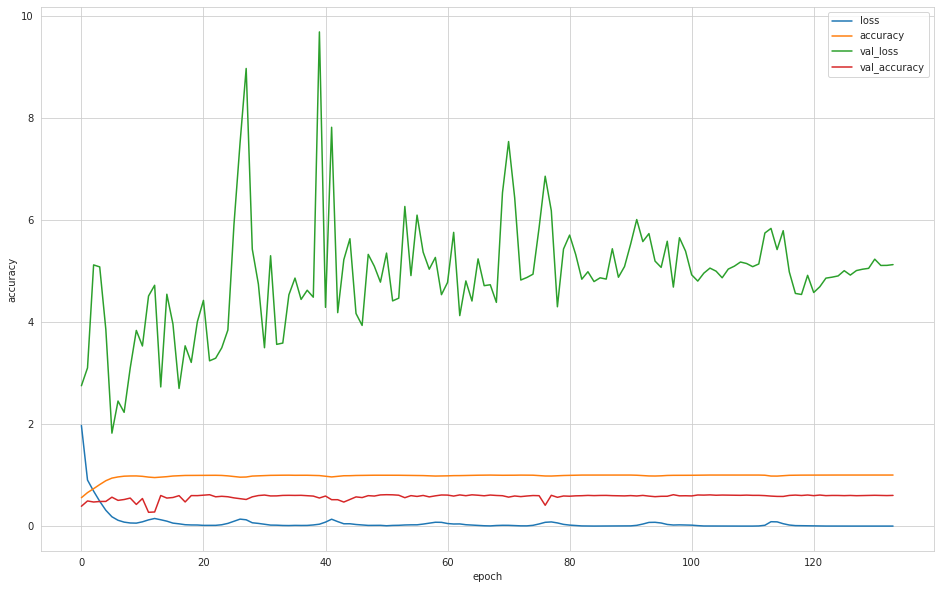

In [18]:
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

## fit
log_path = "logs/"+datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = k.callbacks.TensorBoard(log_dir=log_path, histogram_freq=1)
es = EarlyStopping(monitor="val_loss", patience=ES, mode="auto", verbose=2)

history = model.fit(train_data, train_label,
                    validation_split=0.1,
                    batch_size=BATCH,
                    epochs=EPOCH,
                    verbose=1,
                    callbacks=[es],
                    # callbacks=[es, tensorboard_callback])
                    )
print(history)

## plot
pd.DataFrame(history.history).plot(figsize=(16, 10), grid=1, xlabel="epoch", ylabel="accuracy")
plt.show()


## EVALUATE

In [24]:
loss, acc = model.evaluate(test_data, test_label, verbose=1)

predict = model.predict(test_data)
predicted = np.argmax(predict, axis=1)


86/86 [==============================] - 0s 3ms/step


/home/z/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/z/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/z/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


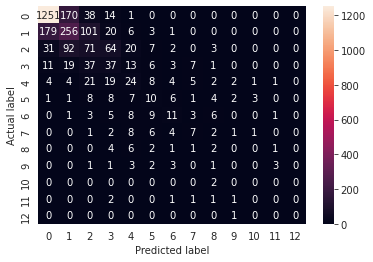

true rate:  1669
false rate:  1060

========== classification_report:  
               precision    recall  f1-score   support

           0       0.85      0.85      0.85      1474
           1       0.47      0.45      0.46       566
           2       0.25      0.24      0.25       290
           3       0.21      0.28      0.24       134
           4       0.25      0.25      0.25        95
           5       0.19      0.20      0.19        51
           6       0.31      0.23      0.27        47
           7       0.28      0.22      0.25        32
           8       0.08      0.12      0.10        17
           9       0.00      0.00      0.00        14
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         6
          12       0.00      0.00      0.00         1

    accuracy                           0.61      2729
   macro avg       0.22      0.22      0.22      2729
weighted avg       0.61      0.61      0.61      2729

======

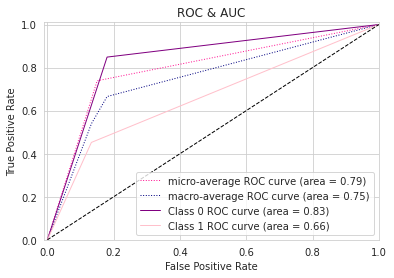

In [25]:
## CM
draw_CM(test_label, predicted)

## ROC, AUC
x = label_binarize(predicted, classes=CLASS)
y = label_binarize(test_label, classes=CLASS)
draw_ROC_AUC(x, y, CLASS)

In [ ]:
if SAVE == 1:
  file_name = "model/light_detector_"+dt.now().strftime("%Y%m%d-%H%M%S")
  model_format = ".h5"
  model_name = file_name+model_format
  model.save(model_name)
